# Table of Contents  <a class="anchor" id="toc"></a>

* [Table of Contents](#toc)

* [Note](#note)

* [Using Graph Algorithms to Enhance Machine Learning](#chapter-8)
    * [Machine Learning and the Importance of Context](#ml-context)
        * [Graphs, Context, and Accuracy](#graphs-context-accuracy)
    * [Connected Feature Engineering](#connected-feature-engineering)
        * [Graphy Features](#graphy)
        * [Graph Algorithm Features](#graph-algorithms)
    * [Graphs and Machine Learning in Practice: Link Prediction](#graph-ml)
        * [Tools and Data](#tools-data)
        * [Importing the Data into Neo4j](#import)
        * [The Coauthorship Graph](#co-authorship)
        * [Creating Balanced Training and Testing Datasets](#balance)
        * [How We Predict Missing Links](#how)
        * [Creating a Machine Learning Pipeline](#create-ml-pipeline)
        * [Predicting Links: Basic Graph Features](#predict-basic)
        * [Predicting Links: Triangles and the Clustering Coefficient](#predict-triangle)
        * [Predicting Links: Community Detection](#predict-community)

# Note  <a class="anchor" id="note"></a>
currently running Neo4j on Singularity 3.8 container because quick way to resolve different dependencies from base OS and simply rebuilding the container if something doesn't work out along the way (it's happend a couple times). Also ease of reproducibility. 

##### To Do :
- create neo4j.def file for singularity
- compare v13 of the data to v10
- provide clear structure and process
- list edits made to neo4j.conf

##### Doing : 
- Apply the same framework to v13 of the data without the JVM Heap running out of memory (i.e. via stream processing, smaller batches, etc.)

##### Done :
- Setup Neo4j

```
singularity build neo4j.sif docker://neo4j
singularity overlay create --size 51280 neo4j.sif'
singularity instance start \ ###Only need to do this once
                             --net --network-args "portmap=7678:7678/tcp" \
                             --bind /path/to/data:/var/lib/neo4j/import \
                             --writable \
                             neo4j.sif neo4j
                             
singularity shell instance://neo4j ###Enter running instance

apt update 
apt upgrade
apt install nano ### or set environment variables/def file beforehand so you dont have to do this

wget <apoc-plugin> -P /var/lib/neo4j/plugins
wget <graph-data-science-plugin> -P /var/lib/neo4j/plugins

nano /var/lib/neo4j/conf/neo4j.conf  ### Enable remote access and plugins

neo4j console 
```

```
### When Outside of shell
singularity exec instance://neo4j neo4j console 
### For whatever reason `neo4j start` doesn't load the config 

```

# Using Graph Algorithms to Enhance Machine Learning <a class="anchor" id="chapter-8"></a>

Most practical way to start improving ML prediction using graph algorithms is using connected feature extraction to predict relationships.

## Machine Learning and the Importance of Context <a class="anchor" id="ml-context"></a>

Machine learning is a method for achieving artificial intelligence (AI) but is not AI in itself.

Achieves progressive improvement based on expected outcomes without explicit programming of how by providing training data to a model for it to learn how to process and encorporate that information.

Learning iteratively and dynamically, able to modify and optimize through batch and stream processing of data.


ML becoming more practical with greater accessibility of large datasets, and parallel compute power.
Fundamental goal to make choices similarly to the way humans do
>Humans use their surrounding context, not just direct data points, to figure out what’s essential in a situation, estimate missing information, and determine how to apply lessons to new situations. Context helps us improve predictions. 

### Graphs, Context, and Accuracy  <a class="anchor" id="graphs-context-accuracy"></a>

Graph-enhanced ML provides missing contextual information to enhance decisions.

Relationships are often strong predictors of behaviour. See [A 61-million-person experiment in social influence and political mobilization](https://www.nature.com/articles/nature11421)

Many ML approaches miss contextual information due to 
- a reliance on data built from tuples, 
- lack of availability,
- difficult access (when available)
- difficult processing 

## Connected Feature Engineering  <a class="anchor" id="connected-feature-engineering"></a>

A foundational step that helps turn raw data into suitable format for training ML models to produce more consistently accurate predictions.


|&nbsp;|&nbsp;|
|-|:-|
|**Feature Extraction**| Distills large volumes of data and attriutes down to a set of representative descriptive attributes. Derives numerical values (features) for distinctive characteristics or patterns in input data so that we can differentiate caegories in other data. Used when data is difficult for a model to analyze directly—perhaps because of size, format, or the need for incidental comparisons.|
|**Feature Selection**| Determines the subset of extracted features that are most important or influential to a target goal. Used to surface predictive impotance as well as for efficiency. i.e. eliminating features of low predictive value|
|**Connected Features**| Features extracted from the structure of the data. Can be derived from graph-local queries based on parts of the graph surrounding a node, or graph-global queries that use graph algorithms to identify predictive elements within data based on relationships for connected feature extraction.|
|**Overfitting**| Models that only work well on training data |
|**Graph Embedding**| Representation of nodes and relationships in a graph as *feature vectors*. Enables graph representation in numerical format ready for machine learning tasks. Useful for unsuprvised learning, data exploration, computing similariy between entities, and reducing dimensionality to aid in statistical analysis|
|**Feature Vectors**| Collections of features that have dimensional mappings|



Example using graph algorithms for feature selection (simplification of [“Unsupervised Graph-Based Feature Selection Via Subspace and PageRank Centrality”](https://bit.ly/2HGON5B)by K. Henniab, N. Mezghani, and C. Gouin-Vallerand.):

1. Link features that discriminate classes to provide an undirected graph
2. Create feature relationships based on cluster density preservation 
3. Compute centrality of features

### Graphy Features  <a class="anchor" id="graphy"></a>

|&nbsp;|&nbsp;|
|-|:-|
|**Graphy Features**| Any number of connection-related metrics about a graph (i.e. count of I/O relationships, count of potential triangles, neighbors in common). Simple to gather and a good test of early hypotheses |

### Graph Algorithm Features  <a class="anchor" id="graph-algorithms"></a>

Can use graph algorithms to find features where general structure is known but not exact patterns.

Combining several types of cconneted features tend to outperform sticking to one single method. \
*See for example*, ["Collective Spammer Detection in Evolving Multi-Relational Social Networks"](https://bit.ly/2TyG6Mm), by S. Fakhraei et al. 
- Authors were able to improve prior detection methods and classify 70% of spammers that had previously required manual labeling, with 90% accuracy by combining multiple methods in a graph enhanced ML workflow


Can use graph algorithms to prioritize features with the most influence and/or co-occurence for model tuning via feature reduction \
*See for example* [“Using PageRank in Feature Selection”, by D. Ienco, R. Meo, and M. Botta."](https://bit.ly/2JDDwVw), by D. Ienco, R. Meo, and M. Botta.


Can use connected features for *link prediction*


|&nbsp;|&nbsp;|
|-|:-|
|**Link Prediction**| Estimates how likely a relationship is to form in the future or whether it should already be present but is missing due to incomplete data. Broadly applicable from product recommendation to drug retargeting and even criminal relationships| 

*See for example*, ["The Link Prediction Problem for Social Networks"](https://bit.ly/2uoyB0q)

## Graphs and Machine Learning in Practice: Link Prediction  <a class="anchor" id="graph-ml"></a>

Data from the [Citation Network Dataset](https://aminer.org/citation), described in the paper “[ArnetMiner: Extraction and Mining of Academic Social Networks](http://bit.ly/2U4C3fb)”, by J. Tang et al. 

This version (v10) contains 3,079,007 papers, 1,766,547 authors, 9,437,718 author relationships, and 25,166,994 citation relationships. We’ll be working with a subset focused on articles that appeared in the following publications:
- Lecture Notes in Computer Science
- Communications of the ACM
- International Conference on Software Engineering
- Advances in Computing and Communications

The resulting dataset contains 51,956 papers, 80,299 authors, 140,575 author relationships, and 28,706 citation relationships. Task to create a coauthors graph based on authors who have collaborated on papers and then predict future collaborations between pairs of authors. Only interested in collaborations between authors
who haven’t collaborated before—we’re not concerned with multiple collaborations between pairs of authors. 

1. Set up the required tools and import the data into Neo4j.
2. Balance data and split samples into Spark DataFrames for training and testing.
3. Explain hypothesis and methods for link prediction 
4. Create a machine learning pipeline in Spark. 
5. Train and evaluate prediction models starting with basic graphy features and adding more graph algorithm features extracted using Neo4j.

### Tools and Data  <a class="anchor" id="tools-data"></a>

In [1]:
from code.script.GraphML import *
%matplotlib inline 

In [2]:
## Setup Apache Spark and Neo4j
### Any function that makes a call to Spark from outside this notebook ends up consuming too much resources, Find a way around this to make the notebook cleaner

spark = SparkSession.builder.appName('GraphML') \
    .config("spark.jars", \
            "/opt/spark-3.0.2-bin-hadoop2.7/jars/spark-tree-plotting-0.2.jar,") \
    .config("spark.driver.extraClassPath", \
            "/opt/spark-3.0.2-bin-hadoop2.7/jars/spark-tree-plotting-0.2.jar") \
    .config("spark.submit.pyFiles", \
           "/opt/spark-3.0.2-bin-hadoop2.7/jars/spark-tree-plotting-0.2.jar") \
    .config("spark.executor.extraClassPath", \
           "/opt/spark-3.0.2-bin-hadoop2.7/jars/spark-tree-plotting-0.2.jar") \
    .getOrCreate() 



### Insert Your Neo4j Credentials
conn = "bolt://<YOUR_NEO4J_IP>:7687"
username = "<YOUR_NEO4J_USERNAME>"
password = "<YOUR_NEO4J_PASS>"

graph = Graph(conn, auth=(username, password))

### Importing the Data into Neo4j  <a class="anchor" id="import"></a>

In [ ]:
graph.run("""
CALL apoc.periodic.iterate(
  'UNWIND ["dblp-ref-0.json","dblp-ref-1.json","dblp-ref-2.json","dblp-ref-3.json"] AS file
   CALL apoc.load.json("file:///" + file)
   YIELD value
   WHERE value.venue IN ["Lecture Notes in Computer Science", "Communications of The ACM",
                         "international conference on software engineering",
                         "advances in computing and communications"]
   return value',
  'MERGE (a:Article {index:value.id})
   ON CREATE SET a += apoc.map.clean(value,["id","authors","references"],[0])
   WITH a,value.authors as authors
   UNWIND authors as author
   MERGE (b:Author{name:author})
   MERGE (b)<-[:AUTHOR]-(a)'
, {batchSize: 10000, iterateList: true});
""")

### This was done once before so cell wasn't rerun


### The Coauthorship Graph  <a class="anchor" id="co-authorship"></a>

In [3]:
graph.run("""
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
SET coauthor.collaborations = collaborations;
""")

(No data)

### Creating Balanced Training and Testing Datasets  <a class="anchor" id="balance"></a>

In [4]:
query = """
MATCH (article:Article)
RETURN article.year AS year, count(*) AS count
ORDER BY year
"""
by_year = graph.run(query).to_data_frame()

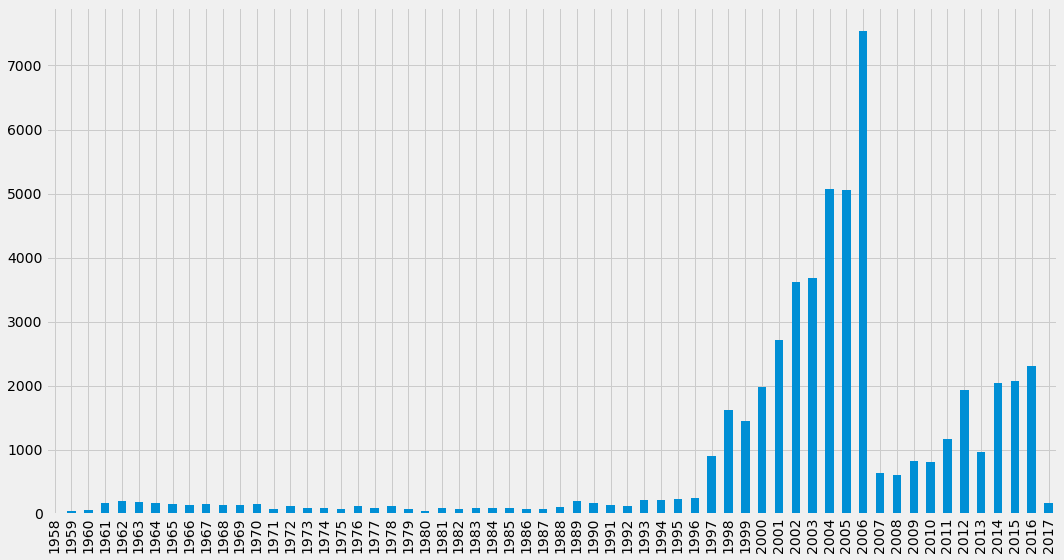

In [5]:
plt.style.use('fivethirtyeight')
ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [6]:
graph.run("""
MATCH (article:Article)
RETURN article.year < 2006 AS training, count(*) AS count
""")

training,count
false,21059
true,30897


#### Create Pre-2006 Coauthorships Feature

In [7]:
graph.run("""
MATCH (a1)-[coAuthor:CO_AUTHOR]-(a2:Author)
WHERE coAuthor.year < 2006
MERGE (a1)-[coauthorEarly:CO_AUTHOR_EARLY {year: coAuthor.year}]-(a2)
SET coauthorEarly.collaborations = coAuthor.collaborations;
""")

(No data)

In [8]:
graph.run("""
MATCH ()-[:CO_AUTHOR_EARLY]->()
RETURN count(*) AS count
""")

count
81096


#### Create Post-2006 Coauthorships

In [9]:
graph.run("""
MATCH (a1)-[coAuthor:CO_AUTHOR]-(a2:Author)
WHERE coAuthor.year >= 2006
MERGE (a1)-[coauthorLate:CO_AUTHOR_LATE {year: coAuthor.year}]-(a2)
SET coauthorLate.collaborations = coAuthor.collaborations;
""")

(No data)

In [10]:
graph.run("""
MATCH ()-[:CO_AUTHOR_LATE]->()
RETURN count(*) AS count
""")

count
74128


#### Balancing and splitting data
Node pairs with `CO_AUTHOR_EARLY` and `CO_AUTHOR_LATE` relationships will act as positive examples 

Training with the existing negative examples is more challenging due to the sheer abundance of them. By simply predicting all nodes won't have a relationship it could achieve high accuracy if trained on all of the negative examples.

To address this challenge negative examples are limited to those nodes within the same neighborhood (roughly 2 or 3 node hops away) that don't have a relationship \
*For details see* ["New Perspectives and Methods in Link Prediction"](https://ntrda.me/2TrSg9K), by R. Lichtenwalter, J. Lussier, and N. Chawla

These are subsquently downsampled to produce an equal number of postive to negative examples

##### Training set

In [11]:
#Note this needs optimization

train_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

train_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()

train_missing_links = train_missing_links.drop_duplicates()
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)



training_data = spark.createDataFrame(training_df)


In [12]:
training_data.show(n=5)

+------+------+-----+
| node1| node2|label|
+------+------+-----+
| 96378| 96376|    1|
|122837|122835|    1|
| 21007| 70866|    0|
|115177| 93760|    1|
| 56461| 51067|    0|
+------+------+-----+
only showing top 5 rows



- label[1] = coauthorship
- label[0] = no coauthorship

In [13]:
training_data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|81096|
|    1|81096|
+-----+-----+



##### Test set

In [14]:
#Note this needs optimization


test_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

test_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_LATE]-()
MATCH (author)-[:CO_AUTHOR*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()

test_missing_links = test_missing_links.drop_duplicates()
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)
test_data = spark.createDataFrame(test_df)


In [15]:
test_data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|74128|
|    1|74128|
+-----+-----+



### How We Predict Missing Links  <a class="anchor" id="how"></a>

#### Assumptions

Hypothesis : most predictive features will be related to communities thus following elements increase the probability that authors become coauthors:
- More coauthors in common
- Potential triadic relationships between authors
- Authors with more relationships
- Authors in the same community
- Authors in the same, tighter community


### Creating a Machine Learning Pipeline  <a class="anchor" id="create-ml-pipeline"></a>

** From function `create_pipeline(fields)` in `GraphML.py`**
```
assembler = VectorAssembler(inputCols=fields, outputCol="features")

rf = RandomForestClassifier(labelCol="label", 
                            featuresCol="features", 
                            numTrees=30, 
                            maxDepth=10
                            )
                            
return Pipeline(stages=[assembler, rf])
```

- `labelCol`
The name of the field containing the variable we want to predict; i.e., whether a
pair of nodes have a link

- `featuresCol`
 The name of the field containing the variables that will be used to predict whether a pair of nodes have a link

- `numTrees`
 The number of decision trees that form the random forest
 
- `maxDepth`
 The maximum depth of the decision trees

### Predicting Links: Basic Graph Features  <a class="anchor" id="predict-basic"></a>

#### Basic model
Predicts whether two authors will have a future collaboration based on features extracted from:

|Feature|Description|
|:-|:-|
|**Common Authors** | Finds the number of potential triangles between two authors. This captures the idea that two authors who have coauthors in common may be introduced and collaborate in the future.|


In [16]:
def apply_graphy_training_features(data):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           size([(p1)-[:CO_AUTHOR_EARLY]-(a)-[:CO_AUTHOR_EARLY]-(p2) | a]) AS commonAuthors,
           size((p1)-[:CO_AUTHOR_EARLY]-()) * size((p2)-[:CO_AUTHOR_EARLY]-()) AS prefAttachment,
           size(apoc.coll.toSet(
             [(p1)-[:CO_AUTHOR_EARLY]-(a) | id(a)] + [(p2)-[:CO_AUTHOR_EARLY]-(a) | id(a)]
           )) AS totalNeighbors
    """
    pairs = [{"node1": row["node1"], "node2": row["node2"]} for row in data.collect()]
    features = spark.createDataFrame(graph.run(query, {"pairs": pairs}).to_data_frame())
    return data.join(features, ["node1", "node2"])

In [17]:
def apply_graphy_test_features(data):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           size([(p1)-[:CO_AUTHOR]-(a)-[:CO_AUTHOR]-(p2) | a]) AS commonAuthors,
           size((p1)-[:CO_AUTHOR]-()) * size((p2)-[:CO_AUTHOR]-()) AS prefAttachment,
           size(apoc.coll.toSet(
             [(p1)-[:CO_AUTHOR]-(a) | id(a)] + [(p2)-[:CO_AUTHOR]-(a) | id(a)]
           )) AS totalNeighbors
    """
    pairs = [{"node1": row["node1"], "node2": row["node2"]} for row in data.collect()]
    features = spark.createDataFrame(graph.run(query, {"pairs": pairs}).to_data_frame())
    return data.join(features, ["node1", "node2"])

##### Apply basic training features

In [18]:
training_data = apply_graphy_training_features(training_data)
test_data = apply_graphy_test_features(test_data)

##### Explore the basic training data

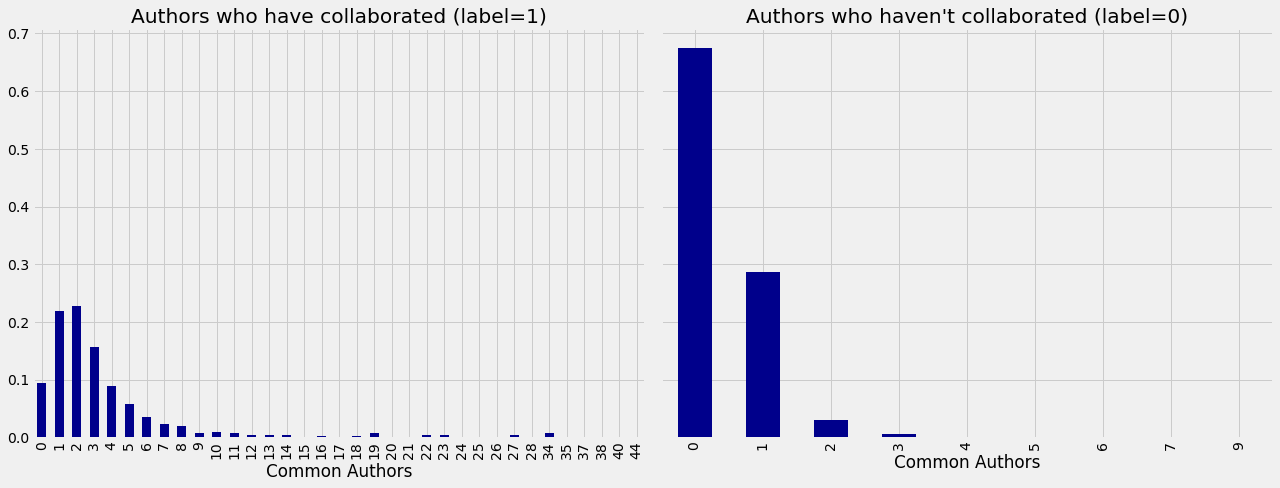

In [19]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]

for index, chart in enumerate(charts):
    label, title = chart
    filtered = training_data.filter(training_data["label"] == label)
    common_authors = filtered.toPandas()["commonAuthors"]
    histogram = common_authors.value_counts().sort_index()
    histogram /= float(histogram.sum())
    histogram.plot(kind="bar", x='Common Authors', color="darkblue", ax=axs[index],
                   title=f"Authors who {title} (label={label})")
    axs[index].xaxis.set_label_text("Common Authors")

plt.tight_layout()
plt.show()

##### Explore Basic Model Feature

In [20]:
collaborators=(training_data.filter(training_data["label"] == 1).toPandas()["commonAuthors"])
collaborators.describe()

count    81096.000000
mean         3.595923
std          4.715942
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         44.000000
Name: commonAuthors, dtype: float64

In [21]:
noncollaborators=(training_data.filter(training_data["label"] == 0).toPandas()["commonAuthors"])
noncollaborators.describe()

count    81096.000000
mean         0.375456
std          0.614478
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          9.000000
Name: commonAuthors, dtype: float64

##### Train Basic Model

In [22]:
basic_model = train_model(["commonAuthors"], training_data)

Manual evaluation

In [23]:
eval_df = spark.createDataFrame(
    [(0,), (1,), (2,), (10,), (100,)],
    ['commonAuthors'])

(basic_model.transform(eval_df)
 .select("commonAuthors", "probability", "prediction")
 .toPandas())

,commonAuthors,probability,prediction
0,0,"[0.7542094265165186, 0.24579057348348143]",0.0
1,1,"[0.7542094265165186, 0.24579057348348143]",0.0
2,2,"[0.05312554284248405, 0.946874457157516]",1.0
3,10,"[0.05312554284248405, 0.946874457157516]",1.0
4,100,"[0.05312554284248405, 0.946874457157516]",1.0


75% probability of no relationship between two authors who share a common author

95% probability of a relationship between two authors who share two common authors

##### Predictive Metrics

| Measure | Formula | Description |
|-|-|:-|
| Accuracy | \begin{equation}\frac{TruePositive + TrueNegatives}{TotalPredictions} \end{equation} | The fraction of predictions our model gets right, or the total number of correct predictions divided by the total number of predictions. Note that accuracy alone can be misleading, especially when our data is unbalanced. For example, if we have a dataset containing 95 cats and 5 dogs and our model predicts that every image is a cat we’ll have a 95% accuracy score despite correctly identifying none of the dogs. |
| Precision | \begin{equation}\frac{TruePositives}{TruePositives+FalsePositives} \end{equation} | The proportion of positive identifications that are correct. A low precision score indicates more false positives. A model that produces no false positives has a precision of 1.0. |
| Recall (true positive rate) | \begin{equation}\frac{TruePositives}{TruePositives+FalseNegatives} \end{equation} | The proportion of actual positives that are identified correctly. A low recall score indicates more false negatives. A model that produces no false negatives has a recall of 1.0. |
| False positive rate | \begin{equation}\frac{FalsePositives}{FalsePositives + TrueNegatives} \end{equation} | The proportion of incorrect positives that are identified. A high score indicates more false positives. |
| Receiver operating characteristic (ROC) curve | X-Y chart | ROC curve is a plot of the Recall (true positive rate) against the False Positive rate at different classification thresholds. The area under the curve (AUC) measures the two-dimensional area underneath the ROC curve from an X-Y axis (0,0) to (1,1). |

##### Evaluate Basic Model

In [24]:
basic_results = evaluate_model(basic_model, test_data)
display_results(basic_results)

,Measure,Score
0,accuracy,0.863844
1,recall,0.753278
2,precision,0.967144


High precision indicates the model is *good at predicting that links exist*

Lower recall in comparison however indicates the model is *not as good at predicting that links don't exist*

##### Plot Basic Model ROC Curve 

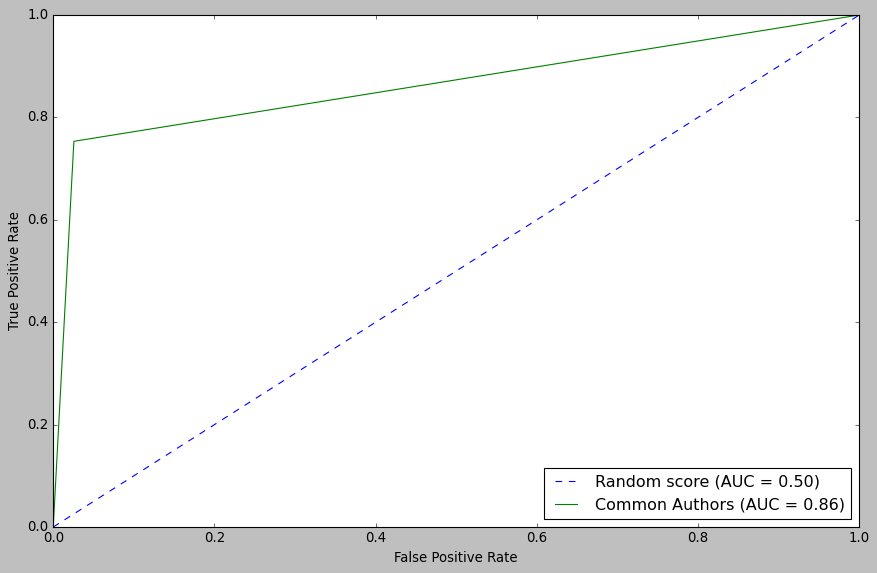

In [25]:
plt, fig = create_roc_plot()

add_curve(plt, "Common Authors",
          basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])

plt.legend(loc='lower right')
plt.show()

#### Graphy model
Predicts whether two authors will have a future collaboration based on features extracted from:

|Feature|Description|
|:-|:-|
|**Common Authors** | Finds the number of potential triangles between two authors. This captures the idea that two authors who have coauthors in common may be introduced and collaborate in the future.|
|**Preferential attachment** | Produces a score for each pair of authors by multiplying the number of coauthors each has. The intuition is that authors are more likely to collaborate with someone who already coauthors a lot of papers.|
|**Total union of neighbors** | Finds the total number of coauthors that each author has, minus the duplicates.|

In [26]:
(training_data.filter(training_data["label"]==1)
 .describe()
 .select("summary", "commonAuthors", "prefAttachment", "totalNeighbors")
 .toPandas())

,summary,commonAuthors,prefAttachment,totalNeighbors
0,count,81096,81096,81096
1,mean,3.5959233501035808,69.93537289138798,10.082408503502021
2,stddev,4.715942231635517,171.47092255919472,8.441099709206844
3,min,0,1,2
4,max,44,3150,90


In [27]:
(training_data.filter(training_data["label"]==0)
 .describe()
 .select("summary", "commonAuthors", "prefAttachment", "totalNeighbors")
 .toPandas())

,summary,commonAuthors,prefAttachment,totalNeighbors
0,count,81096,81096,81096
1,mean,0.3754562493834468,48.300914964979775,12.967026733747657
2,stddev,0.614477974939169,96.32339082283174,10.073604101457319
3,min,0,1,1
4,max,9,2704,90


- Features with a greater divde should be more predictive
- Large standard deviation and min max values of preferential attachment expected for small-world networks with connected hubs

#### Graphy Model

##### Train Graphy Model

In [28]:
fields = ["commonAuthors", 
          "prefAttachment", 
          "totalNeighbors"]

graphy_model = train_model(fields, training_data)

##### Evaluate Graphy Model

In [30]:
graphy_results = evaluate_model(graphy_model, test_data)
display_results(graphy_results)

,Measure,Score
0,accuracy,0.977066
1,recall,0.923727
2,precision,0.943636


Slight precision tradeoff for increased accuracy and recall

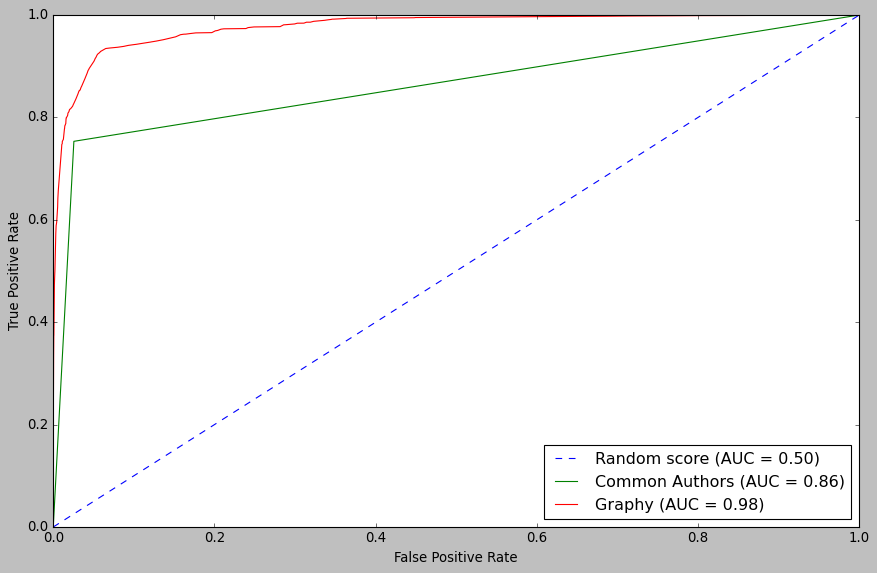

In [31]:
plt, fig = create_roc_plot()

add_curve(plt, "Common Authors",
          basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])

add_curve(plt, "Graphy",
          graphy_results["fpr"], graphy_results["tpr"], graphy_results["roc_auc"])

plt.legend(loc='lower right')
plt.show()

##### Rank the importance of features to prediction

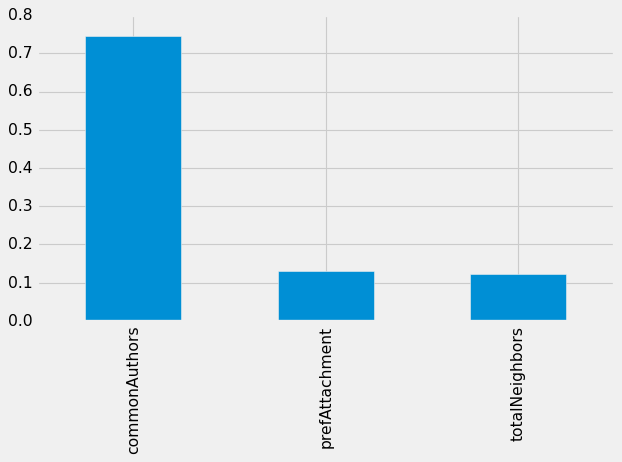

In [32]:
plt.style.use('fivethirtyeight')
rf_model = graphy_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

**▼ ▼ ▼ Come back to this section later once Spark 2.4.8 is setup ▼ ▼ ▼**

In [33]:
from spark_tree_plotting import export_graphviz

dot_string = export_graphviz(rf_model.trees[0],
    featureNames=fields, categoryNames=[], classNames=["True", "False"],
    filled=True, roundedCorners=True, roundLeaves=True)

with open("/tmp/rf.dot", "w") as file:
    file.write(dot_string)


Py4JJavaError: An error occurred while calling o1325.toJsonPlotFormat.
: java.lang.NoClassDefFoundError: scala/Product$class
	at net.liftweb.json.NoTypeHints$.<init>(Formats.scala:221)
	at net.liftweb.json.NoTypeHints$.<clinit>(Formats.scala)
	at net.liftweb.json.Formats$class.$init$(Formats.scala:34)
	at net.liftweb.json.DefaultFormats$.<init>(Formats.scala:252)
	at net.liftweb.json.DefaultFormats$.<clinit>(Formats.scala)
	at com.jasoto.spark.ml.SparkMLTree.toJsonPlotFormat(spark-tree-plotting.scala:87)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.ClassNotFoundException: scala.Product$class
	at java.net.URLClassLoader.findClass(URLClassLoader.java:382)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:418)
	at sun.misc.Launcher$AppClassLoader.loadClass(Launcher.java:352)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:351)
	... 17 more


**▲ ▲ ▲  Come back to this section later once Spark 2.4.8 is setup  ▲ ▲ ▲**

### Predicting Links: Triangles and the Clustering Coefficient  <a class="anchor" id="predict-triangle"></a>

#### Create Triangle Count Feature

In [34]:
graph.run("""
CALL gds.triangleCount.write({
    nodeProjection: 'Author',
    relationshipProjection: {
        CO_AUTHOR_EARLY: {
            type: 'CO_AUTHOR_EARLY',
            orientation: 'UNDIRECTED'
            }
        },
    writeProperty: 'trianglesTrain'
});
""")

writeMillis,nodePropertiesWritten,globalTriangleCount,nodeCount,postProcessingMillis,createMillis,computeMillis,configuration
268,80299,97205,80299,0,221,70,"{writeConcurrency: 4, writeProperty: 'trianglesTrain', maxDegree: 9223372036854775807, nodeLabels: ['*'], sudo: false, relationshipTypes: ['*'], username: null, concurrency: 4}"


In [35]:
graph.run("""
CALL gds.triangleCount.write({
    nodeProjection: 'Author',
    relationshipProjection: {
        CO_AUTHOR: {
            type: 'CO_AUTHOR',
            orientation: 'UNDIRECTED'
            }
        },
    writeProperty: 'trianglesTest'
});
""")

writeMillis,nodePropertiesWritten,globalTriangleCount,nodeCount,postProcessingMillis,createMillis,computeMillis,configuration
152,80299,199813,80299,0,68,93,"{writeConcurrency: 4, writeProperty: 'trianglesTest', maxDegree: 9223372036854775807, nodeLabels: ['*'], sudo: false, relationshipTypes: ['*'], username: null, concurrency: 4}"


#### Create Clustering Coefficient Feature

In [36]:
graph.run("""
CALL gds.localClusteringCoefficient.write({
    nodeProjection: 'Author',
    relationshipProjection: {
        CO_AUTHOR_EARLY: {
            type: 'CO_AUTHOR_EARLY',
            orientation: 'UNDIRECTED'
            }
        },
    writeProperty: 'coefficientTrain'
});
""")

writeMillis,nodePropertiesWritten,averageClusteringCoefficient,nodeCount,postProcessingMillis,createMillis,computeMillis,configuration
210,80299,0.3750745856927135,80299,0,34,62,"{writeConcurrency: 4, triangleCountProperty: null, writeProperty: 'coefficientTrain', nodeLabels: ['*'], sudo: false, relationshipTypes: ['*'], username: null, concurrency: 4}"


In [37]:
graph.run("""
CALL gds.localClusteringCoefficient.write({
    nodeProjection: 'Author',
    relationshipProjection: {
        CO_AUTHOR: {
            type: 'CO_AUTHOR',
            orientation: 'UNDIRECTED'
            }
        },
    writeProperty: 'coefficientTest'
});
""")

writeMillis,nodePropertiesWritten,averageClusteringCoefficient,nodeCount,postProcessingMillis,createMillis,computeMillis,configuration
140,80299,0.6569572285590803,80299,0,42,40,"{writeConcurrency: 4, triangleCountProperty: null, writeProperty: 'coefficientTest', nodeLabels: ['*'], sudo: false, relationshipTypes: ['*'], username: null, concurrency: 4}"


#### Apply TriangleCC Model Features

In [38]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minTriangles,
           apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxTriangles,
           apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minCoefficient,
           apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxCoefficient
    """
    params = {
        "pairs": [{"node1": row["node1"], "node2": row["node2"]} for row in data.collect()],
        "trianglesProp": triangles_prop,
        "coefficientProp": coefficient_prop
    }
    features = spark.createDataFrame(graph.run(query, params).to_data_frame())
    return data.join(features, ["node1", "node2"])

In [39]:
training_data = apply_triangles_features(training_data, "trianglesTrain", "coefficientTrain")
test_data = apply_triangles_features(test_data, "trianglesTest", "coefficientTest")

#### Explore TriangleCC Model Features

In [41]:
(training_data.filter(training_data["label"]==1)
 .describe()
 .select("summary", "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient")
 .toPandas())

,summary,minTriangles,maxTriangles,minCoefficient,maxCoefficient
0,count,81096,81096,81096,81096
1,mean,19.478260333431983,27.73590559337082,0.5703773654487049,0.8453786164620437
2,stddev,65.76152827684825,74.01896188921927,0.3614610553659958,0.29396818573565187
3,min,0,0,0.0,0.0
4,max,622,785,1.0,1.0


In [40]:
(training_data.filter(training_data["label"]==0)
 .describe()
 .select("summary", "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient")
 .toPandas())

,summary,minTriangles,maxTriangles,minCoefficient,maxCoefficient
0,count,81096,81096,81096,81096
1,mean,5.770938147380882,35.50277448949393,0.49028197885576674,0.8612085200969547
2,stddev,20.7692928047257,85.63814179220928,0.3683060364121515,0.2563993069857705
3,min,0,0,0.0,0.0
4,max,595,785,1.0,1.0


Differences between co-authorship and no co-authorship based on triangle features is minimal

#### Train TriangleCC Model

In [42]:
fields =  [
        "commonAuthors", 
         "prefAttachment", 
         "totalNeighbors",
         "minTriangles", 
         "maxTriangles", 
         "minCoefficient", 
         "maxCoefficient"
    ]
triangle_model = train_model(fields,
    training_data)

#### Evaluate Triangle Model

In [43]:
triangle_results = evaluate_model(triangle_model, test_data)
display_results(triangle_results)

,Measure,Score
0,accuracy,0.992583
1,recall,0.962592
2,precision,0.959176


##### Triangle Model ROC Curve

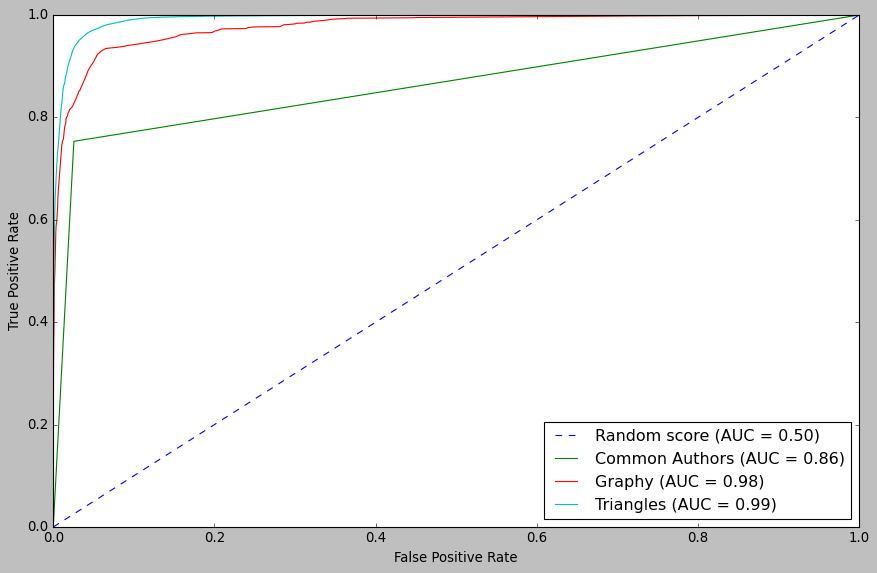

In [44]:
plt, fig = create_roc_plot()

add_curve(plt, "Common Authors",
          basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])

add_curve(plt, "Graphy",
          graphy_results["fpr"], graphy_results["tpr"], graphy_results["roc_auc"])

add_curve(plt, "Triangles",
          triangle_results["fpr"], triangle_results["tpr"], triangle_results["roc_auc"])

plt.legend(loc='lower right')
plt.show()

##### Triangle Model Feature Evaluation

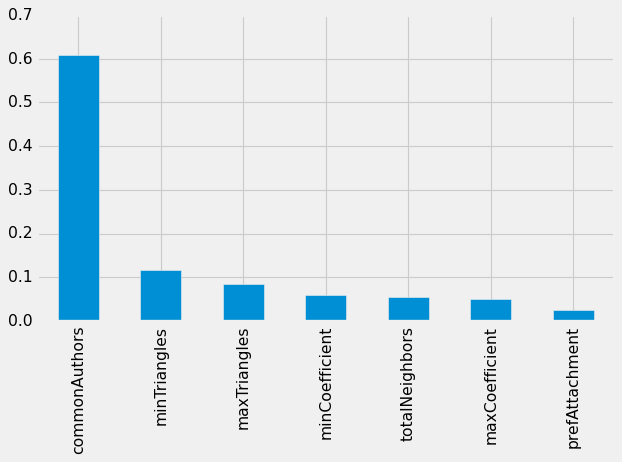

In [45]:
plt.style.use('fivethirtyeight')
rf_model = triangle_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

### Predicting Links: Community Detection  <a class="anchor" id="predict-community"></a>

#### Create Coarse-Grained Communities Using the Label Propagation Algorithm

In [46]:
graph.run("""
CALL gds.labelPropagation.write({
    nodeProjection: "Author",
    relationshipProjection: {
        CO_AUTHOR_EARLY: {
            type: 'CO_AUTHOR_EARLY',
            orientation: 'UNDIRECTED'
        }
    },
    writeProperty: "partitionTrain"
});
""")

writeMillis,nodePropertiesWritten,ranIterations,didConverge,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
690,80299,7,true,43928,"{p99: 15, min: 1, max: 139, mean: 1.8279684938991076, p90: 3, p50: 1, p999: 40, p95: 5, p75: 1}",40,27,171,"{maxIterations: 10, writeConcurrency: 4, seedProperty: null, consecutiveIds: false, relationshipWeightProperty: null, concurrency: 4, writeProperty: 'partitionTrain', nodeLabels: ['*'], sudo: false, nodeWeightProperty: null, relationshipTypes: ['*'], username: null}"


In [47]:
graph.run("""
CALL gds.labelPropagation.write({
    nodeProjection: "Author",
    relationshipProjection: {
        CO_AUTHOR: {
            type: 'CO_AUTHOR',
            orientation: 'UNDIRECTED'
    }
    },
writeProperty: "partitionTest"
});
""")

writeMillis,nodePropertiesWritten,ranIterations,didConverge,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
179,80299,9,true,16456,"{p99: 35, min: 1, max: 360, mean: 4.87961837627613, p90: 10, p50: 3, p999: 99, p95: 15, p75: 5}",28,32,147,"{maxIterations: 10, writeConcurrency: 4, seedProperty: null, consecutiveIds: false, relationshipWeightProperty: null, concurrency: 4, writeProperty: 'partitionTest', nodeLabels: ['*'], sudo: false, nodeWeightProperty: null, relationshipTypes: ['*'], username: null}"


#### Create Fine Grained Communities with the Louvain Algorithm

In [48]:
graph.run("""
CALL gds.louvain.stream({
    nodeProjection: 'Author',
    relationshipProjection: {
        CO_AUTHOR_EARLY: {
            type: 'CO_AUTHOR_EARLY',
            orientation: 'UNDIRECTED'
        }
    },
    includeIntermediateCommunities: true
})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node,
    intermediateCommunityIds[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity;
""")


(No data)

In [49]:
graph.run("""
CALL gds.louvain.stream({
    nodeProjection: 'Author',
    relationshipProjection: {
        CO_AUTHOR: {
            type: 'CO_AUTHOR',
            orientation: 'UNDIRECTED'
        }
    },
    includeIntermediateCommunities: true
})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node,
intermediateCommunityIds[0] AS smallestCommunity
SET node.louvainTest = smallestCommunity;
""")

(No data)

In [50]:
def apply_community_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           CASE WHEN p1[$partitionProp] = p2[$partitionProp] THEN 1 ELSE 0 END AS samePartition,
           CASE WHEN p1[$louvainProp] = p2[$louvainProp] THEN 1 ELSE 0 END AS sameLouvain
    """
    params = {
        "pairs": [{"node1": row["node1"], "node2": row["node2"]} for row in data.collect()],
        "partitionProp": partition_prop,
        "louvainProp": louvain_prop
    }
    features = spark.createDataFrame(graph.run(query, params).to_data_frame())
    return data.join(features, ["node1", "node2"])

In [51]:
training_data = apply_community_features(training_data, "partitionTrain", "louvainTrain")
test_data = apply_community_features(test_data, "partitionTest", "louvainTest")

#### Exploring Community Partition

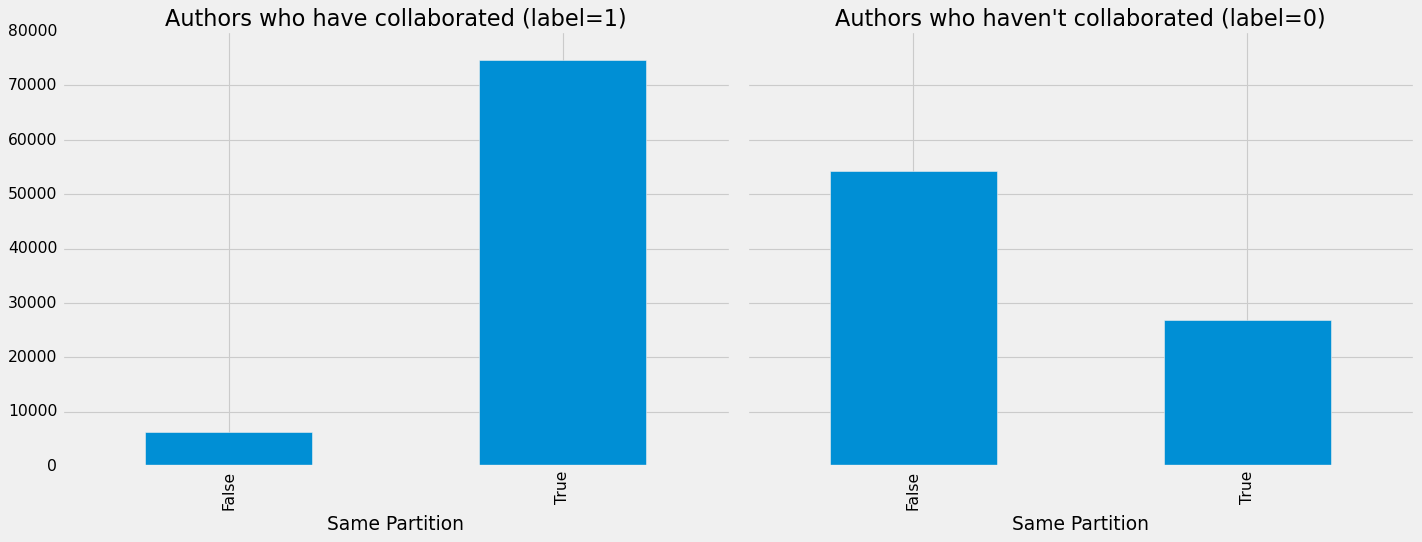

In [52]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]

for index, chart in enumerate(charts):
    label, title = chart
    filtered = training_data.filter(training_data["label"] == label)
    values = (filtered.withColumn('samePartition', F.when(F.col("samePartition") == 0, "False")
                                  .otherwise("True"))
              .groupby("samePartition")
              .agg(F.count("label").alias("count"))
              .select("samePartition", "count")
              .toPandas())
    values.set_index("samePartition", drop=True, inplace=True)
    values.plot(kind="bar", ax=axs[index], legend=None,
                title=f"Authors who {title} (label={label})")
    axs[index].xaxis.set_label_text("Same Partition")

plt.tight_layout()
plt.show()

Authors who have collaborated are more likely to be in the same partition than those who aren't

#### Exploring Community Louvain

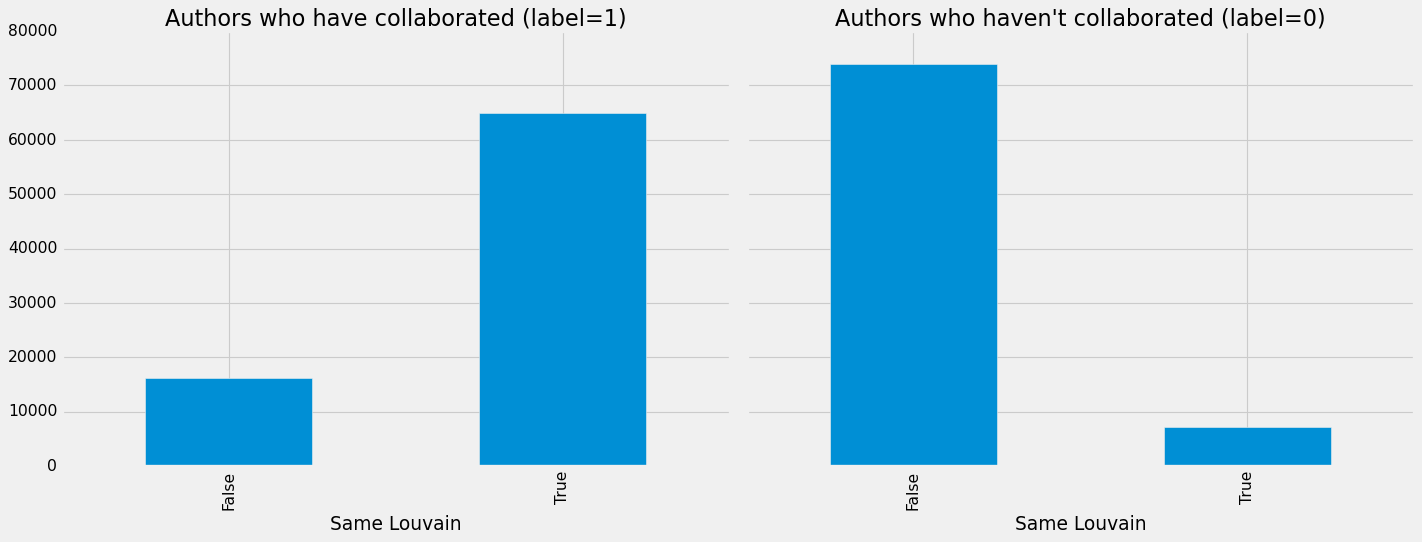

In [53]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]

for index, chart in enumerate(charts):
    label, title = chart
    filtered = training_data.filter(training_data["label"] == label)
    values = (filtered.withColumn('sameLouvain', F.when(F.col("sameLouvain") == 0, "False")
                                  .otherwise("True"))
              .groupby("sameLouvain")
              .agg(F.count("label").alias("count"))
              .select("sameLouvain", "count")
              .toPandas())
    values.set_index("sameLouvain", drop=True, inplace=True)
    values.plot(kind="bar", ax=axs[index], legend=None,
                title=f"Authors who {title} (label={label})")
    axs[index].xaxis.set_label_text("Same Louvain")

plt.tight_layout()
plt.show()

Authors who have collaborated are likely to be in the same cluster

Authors who haven't collaborated are unlikely to be in the same cluster

#### Train Community Model

In [54]:
fields = ["commonAuthors", 
          "prefAttachment", 
          "totalNeighbors",
          "minTriangles", 
          "maxTriangles", 
          "minCoefficient", 
          "maxCoefficient",
          "samePartition", 
          "sameLouvain"]

community_model = train_model(fields, training_data)

#### Evaluate Community Model

In [55]:
community_results = evaluate_model(community_model, test_data)
display_results(community_results)

,Measure,Score
0,accuracy,0.995888
1,recall,0.968878
2,precision,0.978115


Slight improvement in all measures

##### Community Model ROC Curve

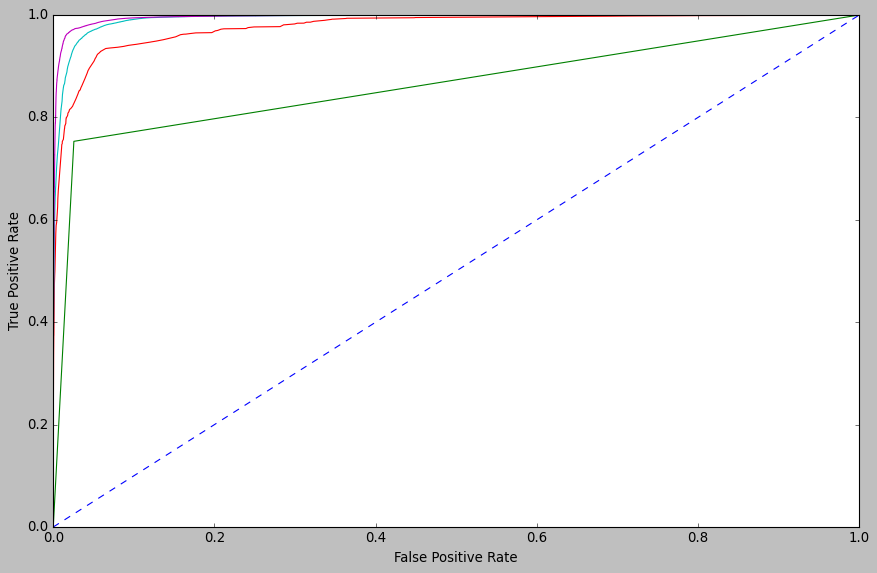

In [56]:
plt, fig = create_roc_plot()

add_curve(plt, "Common Authors",
          basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])

add_curve(plt, "Graphy",
          graphy_results["fpr"], graphy_results["tpr"], graphy_results["roc_auc"])

add_curve(plt, "Triangles",
          triangle_results["fpr"], triangle_results["tpr"], triangle_results["roc_auc"])

add_curve(plt, "Community",
          community_results["fpr"], community_results["tpr"], community_results["roc_auc"])

Visible improvemment

##### Community Model Feature Importance

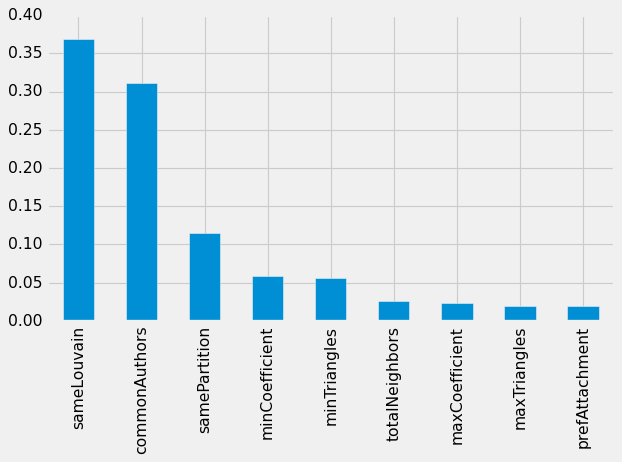

In [57]:
plt.style.use('fivethirtyeight')
rf_model = community_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

Random forest classifier using features derived from Community detection algorithms have a notable influence in addition to the commonAuthors feature on this data supporting the hypothesis that the most predictive features of future coauthorship are related to communities